In [186]:
import simulation
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf


In [187]:
def map_int_to_direction(input):
    if input == 0:
        return simulation.Direction.North
    if input == 1:
        return simulation.Direction.East
    if input == 2:
        return simulation.Direction.South
    else:
        return simulation.Direction.West

In [188]:
env = simulation.init_environment_python(7,7)
simulation.create_kruzkals_maze(env)

In [189]:
def action_result_to_tuple(action_result):
    """
    Converts an ActionResult object into a tuple.

    Args:
        action_result (ActionResult): The result of an action in the environment.

    Returns:
        tuple: (observation, reward, done, truncated, info)
    """
    observation = action_result.observation  # The new observation after taking action
    reward = action_result.reward  # Reward received
    done = action_result.is_done  # Whether the episode is finished
    truncated = action_result.is_truncated  # Whether the episode was truncated
    info = {
        "manhattan_distance": action_result.info.manhattan_distance
    }  # Additional info

    return observation, reward, done, truncated, info


In [190]:
def action_result_to_input_vector(state):
    available_paths = state.available_paths
    return np.array([
        int(simulation.Direction.North in available_paths),
        int(simulation.Direction.South in available_paths),
        int(simulation.Direction.East in available_paths),
        int(simulation.Direction.West in available_paths),
        state.current_location[0] / 7,
        state.current_location[1] / 7,
        state.end_node[0] / 7,
        state.end_node[1] / 7,
    ])

In [191]:
tf.random.set_seed(42)  # extra code – ensures reproducibility on the CPU

input_shape = [8]  # == env.observation_space.shape
n_outputs = 4  # == env.action_space.n

model = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation="elu", input_shape=input_shape),
    tf.keras.layers.Dense(32, activation="elu"),
    tf.keras.layers.Dense(n_outputs)
])

/home/art/Development/FYP/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [192]:
def epsilon_greedy_policy(state, epsilon=0):
    if np.random.rand() < epsilon:
        return np.random.randint(n_outputs)  # random action
    else:
        Q_values = model.predict(state[np.newaxis], verbose=0)[0]
        return Q_values.argmax()  # optimal action according to the DQN

In [193]:
from collections import deque

replay_buffer = deque(maxlen=2000)

In [194]:
def sample_experiences(batch_size):
    indices = np.random.randint(len(replay_buffer), size=batch_size)
    batch = [replay_buffer[index] for index in indices]
    return [
        np.array([experience[field_index] for experience in batch])
        for field_index in range(6)
    ]  # [states, actions, rewards, next_states, dones, truncateds]

In [195]:
def play_one_step(env, state, epsilon):
    flat_state = action_result_to_input_vector(state)
    action = epsilon_greedy_policy(flat_state, epsilon)
    action_obj = simulation.create_action(map_int_to_direction(action))
    next_state, reward, done, truncated, info = action_result_to_tuple(env.take_action(action_obj))
    flat_next_state = action_result_to_input_vector(next_state)
    replay_buffer.append((flat_state, action, reward, flat_next_state, done, truncated))
    if done:
        reward = 100  # give a large positive reward for reaching the goal
    else:
        reward = reward 
    return next_state, reward, done, truncated, info

In [196]:
np.random.seed(42)
tf.random.set_seed(42)
rewards = [] 
lowest_steps = 500

In [197]:
batch_size = 32
discount_factor = 0.95
optimizer = tf.keras.optimizers.Nadam(learning_rate=1e-2)
loss_fn = tf.keras.losses.MeanSquaredError()  # Use the class
def training_step(batch_size):
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones, truncateds = experiences
    next_Q_values = model.predict(next_states, verbose=0)
    max_next_Q_values = next_Q_values.max(axis=1)
    runs = 1.0 - (dones | truncateds)  # episode is not done or truncated
    target_Q_values = rewards + runs * discount_factor * max_next_Q_values
    target_Q_values = target_Q_values.reshape(-1, 1)
    mask = tf.one_hot(actions, n_outputs)
    with tf.GradientTape() as tape:
        all_Q_values = model(states)
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))

    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

In [198]:
steps = 500

for episode in range(30):
    result = env.reset()   
    obs, reward, done, truncated, info = action_result_to_tuple(result)
    for step in range(steps):
        epsilon = max(1 - episode / 75, 0.01)
        obs, reward, done, truncated, info = play_one_step(env, obs, epsilon)
        if done or truncated:
            break

    # extra code – displays debug info, stores data for the next figure, and
    #              keeps track of the best model weights so far
    print(f"\rEpisode: {episode + 1}, Steps: {step + 1}, eps: {epsilon:.3f}",
          end="")
    rewards.append(steps - step)
    if step <= lowest_steps:
        best_weights = model.get_weights()
        lowest_steps = step

    if episode > 30:
        training_step(batch_size)
    with open(f'../mazeLogs/solve{episode}.json', 'w') as file:
        file.write(env.to_json())
model.set_weights(best_weights)  # extra code – restores the best model weights

Episode: 30, Steps: 18, eps: 0.6137

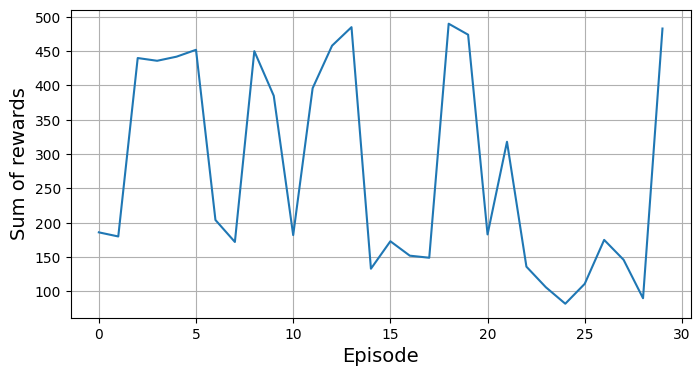

In [199]:
# extra code – this cell generates and saves Figure 18–10
plt.figure(figsize=(8, 4))
plt.plot(rewards)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Sum of rewards", fontsize=14)
plt.grid(True)
plt.show()